In [1]:
import numpy as np
import cv2 as cv
import sys
import typing
from abc import ABC, abstractmethod
import enum
import matplotlib.pyplot as plt

In [2]:
class SuppScalingAlgorithms(enum.Enum):
    NEAREST = 100
    LINEAR = 200
    CUBIC = 300
    LANCZOS = 400
    AREA = 500

## Abstract class for scaling approach

The setup for a scaling approach.

 Includes the library (e.g. PIL or OpenCV) and the interpolation algorithm.
 
This class saves the CL, CR, interpolation algorithm and the image sizes before and after.

The reason is that CL and CR are only valid for a fixed size in combination with the right interpolation algorithm, so that we should not save them separately.

param algorithm: can be 'int' if this value corresponds to the algorithm value from the library, e.g. we use OpenCV and pass INTER_LINEAR (which is int); or this is SuppScalingAlgorithms, so that we determine the necessary library parameter automatically.

In [3]:
class ScalingApproach(ABC):
    def __init__(self,
                 algorithm: typing.Union[int, SuppScalingAlgorithms],
                 src_image_shape: typing.Union[typing.Tuple[int, int], typing.Tuple[int, int, int]],
                 target_image_shape: typing.Union[typing.Tuple[int, int], typing.Tuple[int, int, int]]):

        assert isinstance(algorithm, int) or isinstance(algorithm, SuppScalingAlgorithms)
        if isinstance(algorithm, SuppScalingAlgorithms):
            algorithm = self._convert_suppscalingalgorithm(algorithm)
        self.algorithm = algorithm
        self.src_image_shape = src_image_shape
        self.target_image_shape = target_image_shape
        self.cl_matrix, self.cr_matrix = self.__get_matrix_cr_cl()

    @abstractmethod
    def scale_image_with(self, xin: np.ndarray, trows: int, tcols: int) -> np.ndarray:
        pass

    # Scales image w.r.t to target image shape
    def scale_image(self, xin: np.ndarray) -> np.ndarray:
        return self.scale_image_with(xin=xin, trows=self.target_image_shape[0], tcols=self.target_image_shape[1])

     # Convert enum for common algorithm specification to scaling library value.
    @abstractmethod
    def _convert_suppscalingalgorithm(self, algorithm: SuppScalingAlgorithms):
        pass

 # Helper Function for Coefficients Recovery (to get CL and CR matrix)
    def __get_scale_cr_cl(self, sh, trows, tcols):
        mint = 255
        im_max = mint * np.identity(sh)
        im_max_scaled = self.scale_image_with(xin=im_max, trows=trows, tcols=tcols)
        Cm = im_max_scaled / 255
        return Cm

   # Coefficients Recovery
    def __get_matrix_cr_cl(self):
        CL = self.__get_scale_cr_cl(sh=self.src_image_shape[0],
                                    trows=self.target_image_shape[0],
                                    tcols=self.src_image_shape[0])
        CR = self.__get_scale_cr_cl(sh=self.src_image_shape[1],
                                    tcols=self.target_image_shape[1],
                                    trows=self.src_image_shape[1])
        # print(CL.shape, CR.shape)
        # normalize
        CL = CL / CL.sum(axis=1)[:, np.newaxis]
        CR = CR / CR.sum(axis=0)[np.newaxis, :]
        return CL, CR

    def get_unique_approach_identifier(self) -> str:
        return str(self.algorithm) + "-" + str(type(self).__name__)

##  Interface for image-scaling attack.

Peform the scaling attack. Input can have the shape [rows, cols, channels] for color images

        or [rows, cols] for gray-scale images.
        :param src_image: source image of attack
        :param target_image: target image of attack
        :param scaler_approach: scaling approach object, defines library and algorithm to be used..
        :return: resulting attack image (as np.uint8), list of objective function values, list of objective function values

Main attack, performs the attack first in horizontal direction and then in vertical direction.
 
 Performs the attack on one channel.
 
        :param src_image:
        :param target_image:
        :param scaler_approach:
        :return: attack image, and opt values for horizontal and vertical direction.

In [4]:
class ScaleAttackStrategy(ABC):
    def __init__(self, verbose: bool):
        self.verbose = verbose

    def attack(self, src_image: np.ndarray, target_image: np.ndarray,
               scaler_approach: ScalingApproach) \
            -> typing.Tuple[np.ndarray, typing.List[np.ndarray], typing.List[np.ndarray]]:

        # ensure that range is in [0, 255]
        assert np.max(src_image) < 255.01 and np.min(src_image) >= -0.0001
        assert np.max(target_image) < 255.01 and np.min(src_image) >= -0.0001
        if src_image.dtype != np.uint8 or target_image.dtype != np.uint8:
            raise Exception("Source or target image have dtype != np.uint8; actually the attack also works "
                            "with float values, as long as they are in the range [0, 255]. So if you know "
                            "what you are doing, you can remove this exception. But keep in mind that the "
                            "return type of the attack image will be np.uint8 even if the input is e.g. np.float64. "
                            "If you need other ranges, you need to adapt our implementation, but the attack works "
                            "for any range in theory.")

        if len(src_image.shape) == 2:
            if self.verbose is True:
                print("*** 2D ***")
            result_attack_image, opt_values1, opt_values2 = self._attack_ononedimension(src_image=src_image,
                                              target_image=target_image,
                                              scaler_approach=scaler_approach)
            result_attack_image = result_attack_image.astype(np.uint8)
            return result_attack_image, [opt_values1], [opt_values2] # ensure that output format is correct

        else:
            result_attack_image = np.zeros(src_image.shape)
            opt_values1 = []
            opt_values2 = []

            for ch in range(src_image.shape[2]):
                if self.verbose is True:
                    print("Channel:", ch)
                attack_image_all, opt_values1_all, opt_values2_all = self._attack_ononedimension(src_image=src_image[:, :, ch],
                                                                              target_image=target_image[:, :, ch],
                                                                              scaler_approach=scaler_approach)
                result_attack_image[:, :, ch] = attack_image_all
                opt_values1.append(opt_values1_all)
                opt_values2.append(opt_values2_all)

            result_attack_image = result_attack_image.astype(np.uint8)
            return result_attack_image, opt_values1, opt_values2

    @abstractmethod
    def _attack_ononedimension(self, src_image: np.ndarray, target_image: np.ndarray,
               scaler_approach: ScalingApproach) \
            -> typing.Tuple[np.ndarray, np.ndarray, np.ndarray]:
        pass

## Implementing the direct nearest neighbor image scaling attack

In [5]:
class DirectNearestScaleAttack(ScaleAttackStrategy):
    def __init__(self, verbose: bool):
        super().__init__(verbose)
        self.round_to_integer = True

    def _attack_ononedimension(self, src_image: np.ndarray, target_image: np.ndarray,
                               scaler_approach: ScalingApproach) -> typing.Tuple[np.ndarray, np.ndarray, np.ndarray]:
        if scaler_approach.algorithm != cv.INTER_NEAREST:
            print("Warning. No inter_nearest used as interpolation", file=sys.stderr)

        dir_attack_image = np.copy(src_image)
        scale_factor_hz = src_image.shape[1] / target_image.shape[1]
        scale_factor_vt = src_image.shape[0] / target_image.shape[0]

        for r in range(0, target_image.shape[0]):
            for c in range(0, target_image.shape[1]):
                dir_attack_image[int(np.floor(r * scale_factor_vt)), int(np.floor(c * scale_factor_hz))] = target_image[r, c]

        return dir_attack_image, np.zeros(1), np.zeros(1)

#if __name__ == "__main__":
  #  src_image = np.random.randint(0, 256, size=(100, 100, 3), dtype=np.uint8)
    #target_image = np.random.randint(0, 256, size=(50, 50, 3), dtype=np.uint8)

## scaling approach

In [7]:
# Define a scaling approach
class NearestScalingApproach(ScalingApproach):
    def scale_image_with(self, xin: np.ndarray, trows: int, tcols: int) -> np.ndarray:
        return cv.resize(xin, (tcols, trows), interpolation=cv.INTER_NEAREST)

    def _convert_suppscalingalgorithm(self, algorithm: SuppScalingAlgorithms):
        return cv.INTER_NEAREST

if __name__ == "__main__":
    src_image = cv.imread("C:/Users/wania/OneDrive/Desktop/GTSRB Dataset/pics/70.png")  
    target_image = cv.imread("C:/Users/wania/OneDrive/Desktop/GTSRB Dataset/pics/no.jpg")

    if src_image is None or target_image is None:
        print("Error loading images")
        sys.exit()

    target_image = cv.resize(target_image, (50, 50))

    scaler_approach = NearestScalingApproach(algorithm=cv.INTER_NEAREST,
                                             src_image_shape=src_image.shape,
                                             target_image_shape=target_image.shape)

    # Perform the attack
    attack = DirectNearestScaleAttack(verbose=True)
    attacked_image, _, _ = attack._attack_ononedimension(src_image, target_image, scaler_approach)

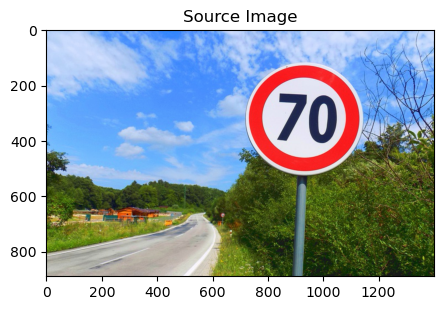

In [9]:
plt.figure(figsize=(5, 5))
plt.imshow(cv.cvtColor(src_image, cv.COLOR_BGR2RGB))
plt.title('Source Image')
plt.axis('on')
plt.show()

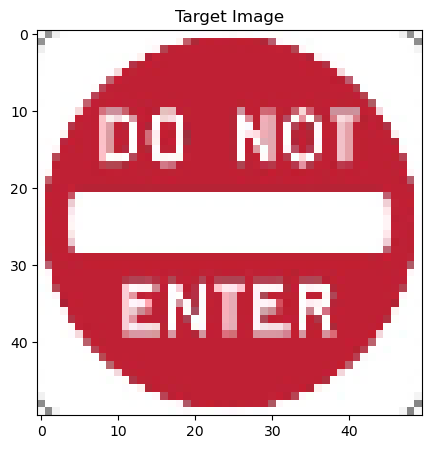

In [10]:
plt.figure(figsize=(5, 5))
plt.imshow(cv.cvtColor(target_image, cv.COLOR_BGR2RGB))
plt.title('Target Image')
plt.axis('on')
plt.show()

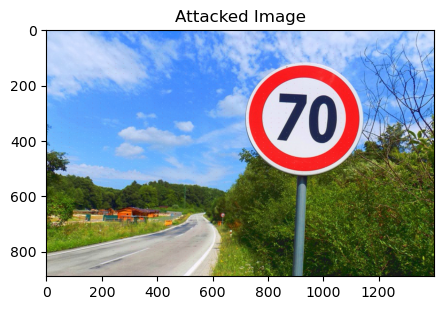

In [11]:
plt.figure(figsize=(5, 5))
plt.imshow(cv.cvtColor(attacked_image, cv.COLOR_BGR2RGB))
plt.title('Attacked Image')
plt.axis('on')
plt.show()